# ДЗ 1 Работа с соскрапленным датасетом

## Загружаем датасет

In [1]:
import dill
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt

In [2]:
OUTPUT_PATH = "../artifacts/cian_dataset.dill"

In [3]:
with open(OUTPUT_PATH, "rb") as f:
    try:
        df = dill.load(f)
    except Exception as e:
        print(f"Ошибка загрузки существующих данных: {e}")

In [4]:
df.head()

,object_title,object_subtitle,jk_name,deadline,geo,price,meter_price,desc
0,"2-комн. квартира, 86,1 м², 4/13 этаж",Секция 1 • Сдача корпуса 3 кв. 2027,ЖК «Клубный город-парк «Фрунзенская набережная»,сдача ГК: 3 кв. 2027 года,"Москва, ЦАО, р-н Хамовники, м. Фрунзенская, Фр...",233 470 000 ₽,2 711 614 ₽/м²,"Уютная квартира с двумя спальными комнатами, п..."
1,"2-комн. апартаменты, 104,2 м², 5/9 этаж",Секция 1 • Сдан,ЖК «Vesper Tverskaya»,дом сдан,"Москва, ЦАО, р-н Тверской, м. Маяковская, 1-я ...",174 388 599 ₽,1 673 595 ₽/м²,Продаются апартаменты с сервисом 5* отеля на 5...
2,"2-комн. апартаменты, 173,3 м², 1/6 этаж",Секция Подъезд 1 • Сдача корпуса 3 кв. 2027,ЖК «Клубный дом Левенсон»,сдача ГК: 3 кв. 2027 года,"Москва, ЦАО, р-н Пресненский, м. Пушкинская, П...",467 910 000 ₽,2 700 000 ₽/м²,"Продаются апартаменты общей площадью 173,3 кв...."
3,Студия. Выдача ключей!,"Студия, 26,57 м², 5/20 этаж",ЖК «FORST»,сдача ГК: 1 кв. 2025 года,"Москва, ЮАО, р-н Даниловский, м. Тульская, Фор...",13 405 991 ₽,504 554 ₽/м²,Выдача ключей! Квартира с отделкой White Box M...
4,"2-комн. квартира, 59,6 м², 15/49 этаж",Секция 1 • Сдача корпуса 2 кв. 2027,ЖК «TATE »,No_content,"Москва, СВАО, р-н Марьина роща, м. Марьина Рощ...",25 411 342 ₽,426 365 ₽/м²,Продается 2-комнатная квартира от застройщика ...


In [5]:
df.shape

(1603, 8)

In [6]:
# В наших данных бывают пропуски, обозначенные стрингой "No_content"

(df == "No_content").any() 

object_title       False
object_subtitle     True
jk_name             True
deadline            True
geo                 True
price               True
meter_price        False
desc               False
dtype: bool

## EDA

### Визуализация пропусков

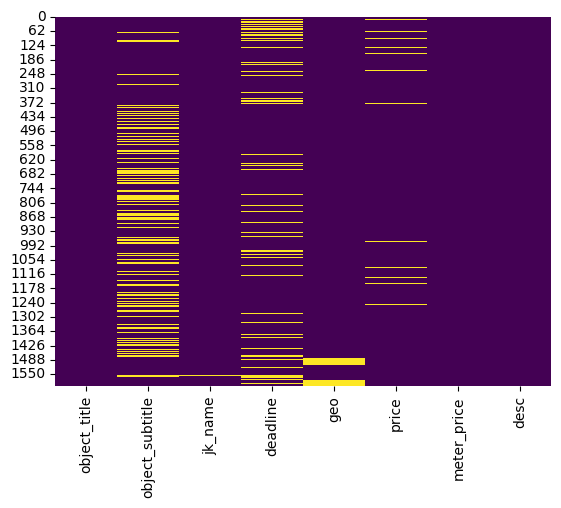

In [7]:
sns.heatmap((df == "No_content"), cbar=False, cmap='viridis')
plt.show()

### План EDA и визуализаций

1. Разделить строку в столбце geo по запятым, с отдельными значениями в каждой колонке.
2. Очистить от нечисловых символов колонки price, meter_price, построить их распределения.
3. Построить распределение jk_name по уникальным объектам.
4. Визуализировать зависимости price/deadline, meter_price/deadline
5. Выделить количество комнат и метров квадратных в отдельные колонки из колонок object_title, object_subtitle.
6. Выделить значение x/y этаж в отдельные колонки из колонок object_title, object_subtitle.
7. Визуализировать зависимости этаж/цена, метро (4е значение в строке geo)/цена

In [8]:
# 1. Разделить строку в столбце geo по запятым
geo_split = df['geo'].str.split(',', expand=True)
geo_split.columns = ['geo_' + str(i) for i in range(geo_split.shape[1])]
df = pd.concat([df, geo_split], axis=1)

In [9]:
df["price"].isna().any()

np.False_

In [10]:
# 2. Очистить от нечисловых символов колонки price, meter_price.
df["price"] = (
    df["price"]
    .str.replace(r"[^\d]", "", regex=True)
    .replace("", np.nan)
    #.dropna()  # Пропуски пока оставим
    .astype(float)  
    .astype("Int64")  # Делаем тип данных целым, но поддерживающим NaN
)
df["meter_price"] = df["meter_price"].str.replace(r"[^\d]", "", regex=True).astype(int)



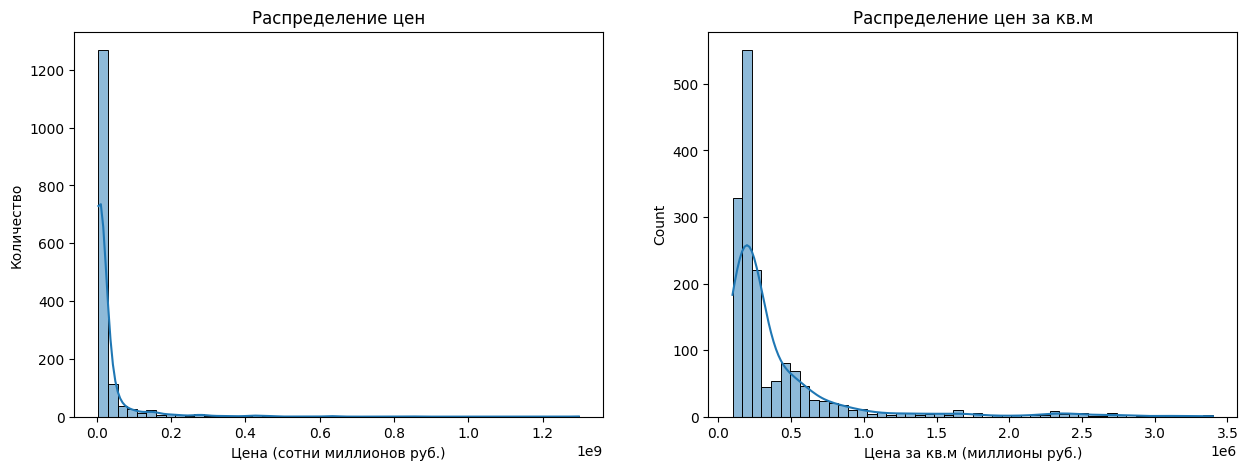

In [11]:
# Построение распределений
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['price'].dropna(), bins=50, kde=True)
plt.title('Распределение цен')
plt.xlabel('Цена (сотни миллионов руб.)')
plt.ylabel('Количество')

plt.subplot(1, 2, 2)
sns.histplot(df['meter_price'].dropna(), bins=50, kde=True)
plt.title('Распределение цен за кв.м')
plt.xlabel('Цена за кв.м (миллионы руб.)')
plt.show()

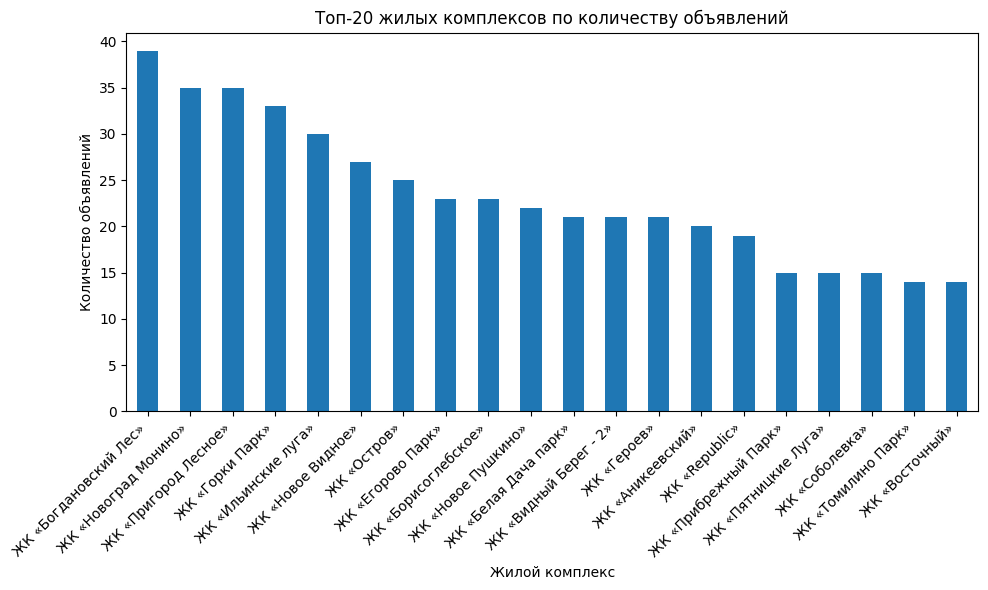

In [12]:
# 3. Распределение jk_name по уникальным объектам
jk_counts = df['jk_name'].value_counts().head(20)  # топ-20 ЖК

plt.figure(figsize=(10, 6))
jk_counts.plot(kind='bar')
plt.title('Топ-20 жилых комплексов по количеству объявлений')
plt.xlabel('Жилой комплекс')
plt.ylabel('Количество объявлений')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

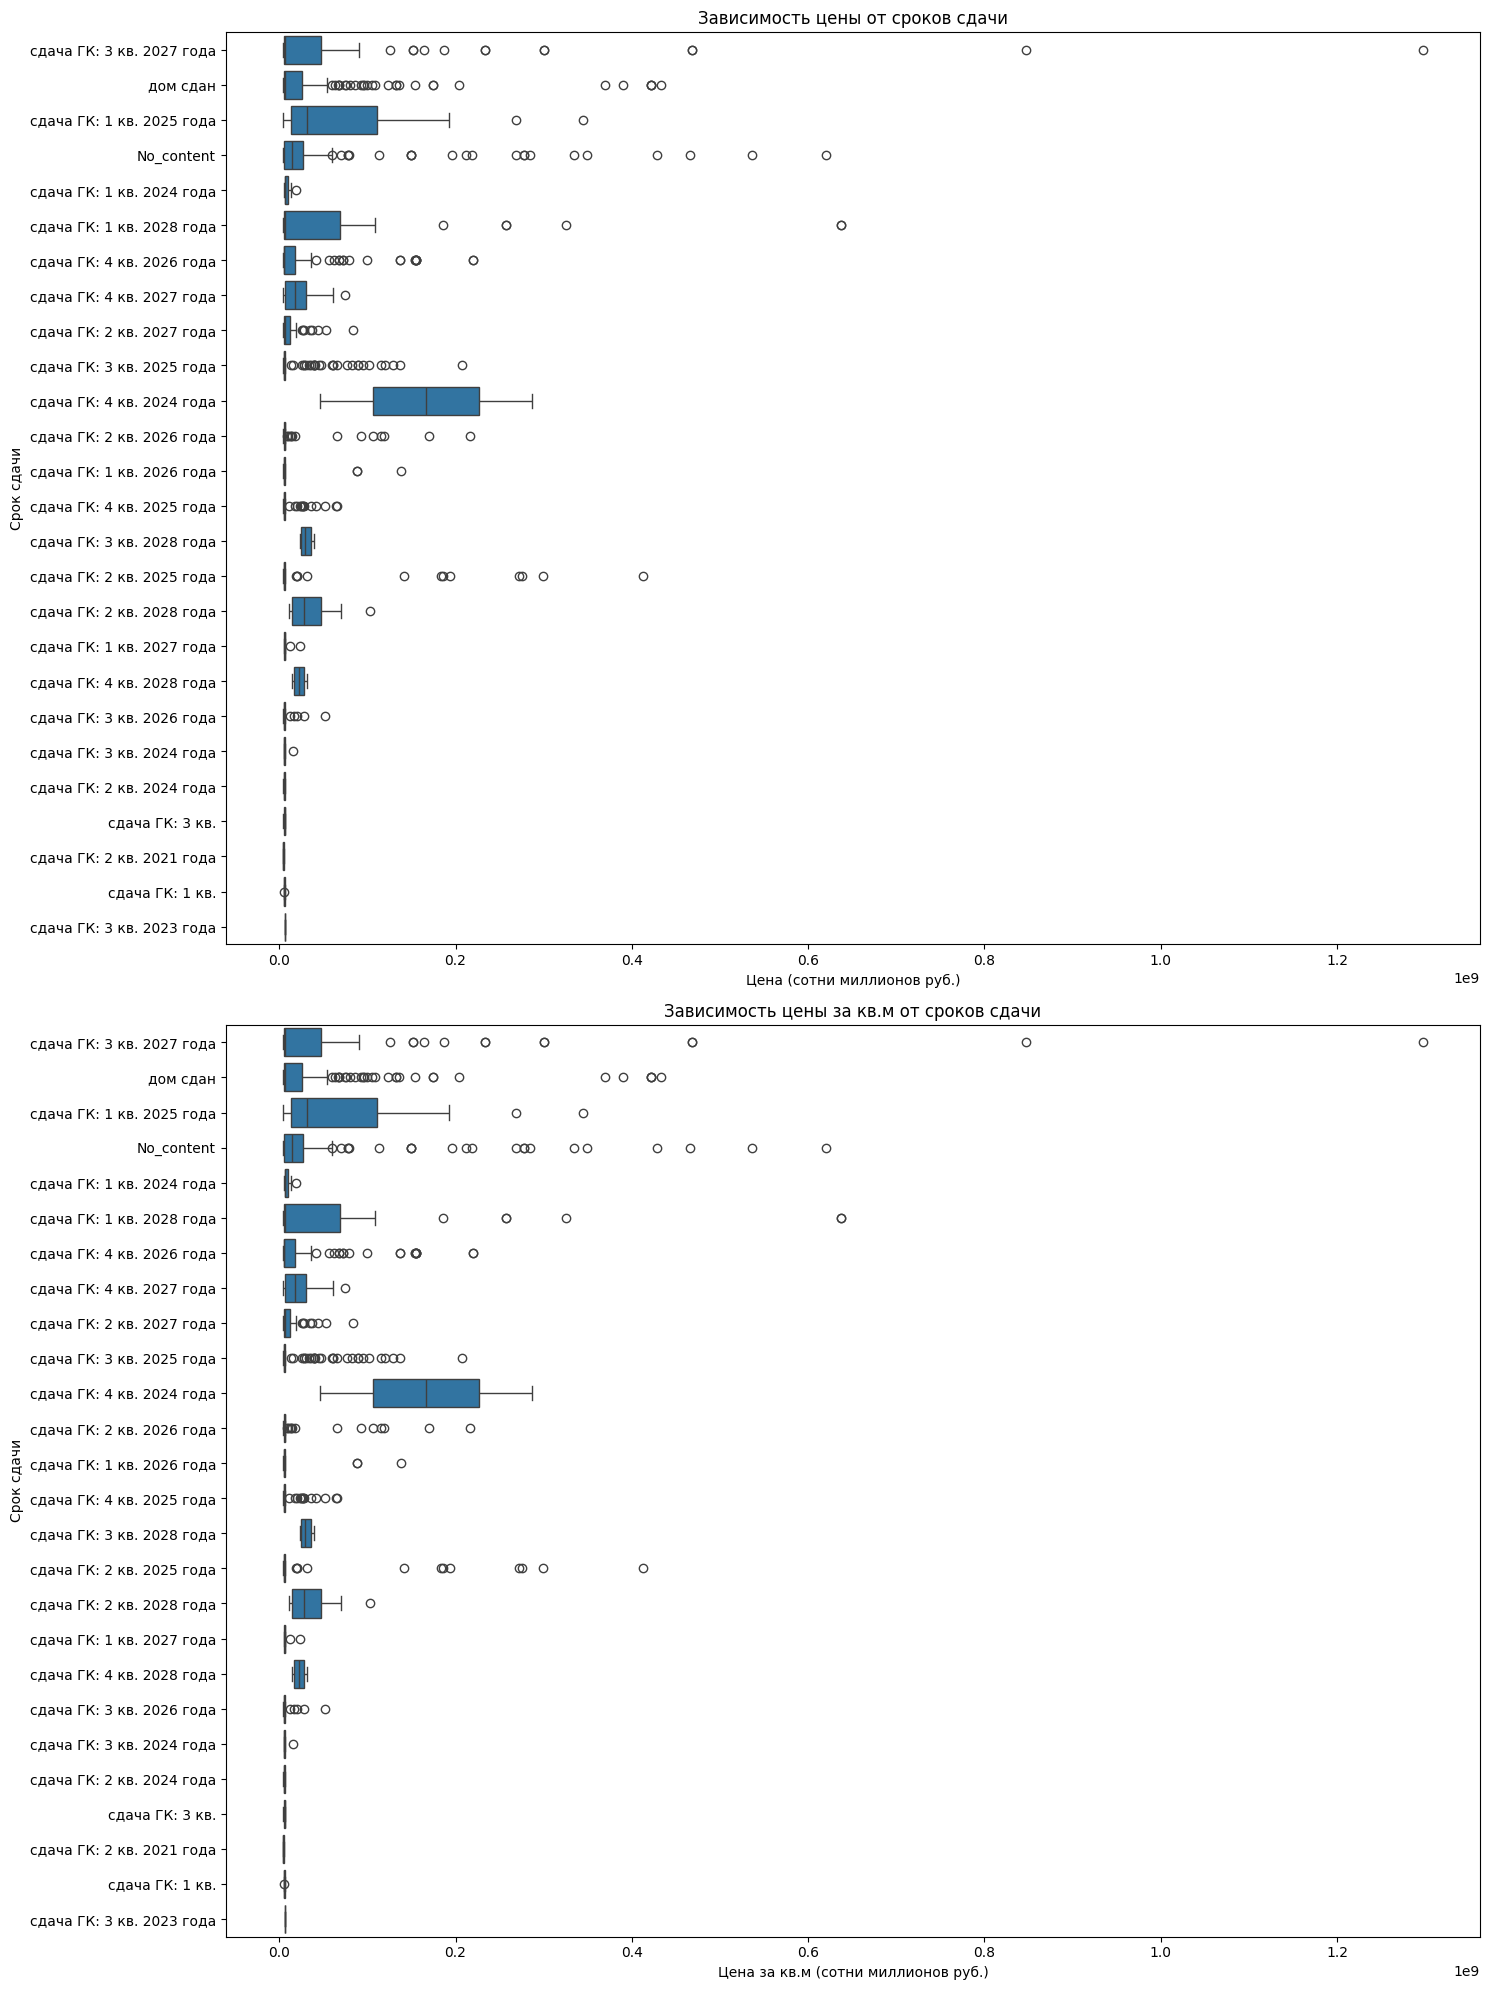

In [13]:
# 4. Визуализация зависимостей price/deadline, meter_price/deadline
plt.figure(figsize=(15, 20))

plt.subplot(2, 1, 1)
sns.boxplot(data=df, x='price', y='deadline')
plt.title('Зависимость цены от сроков сдачи')
plt.xlabel('Цена (сотни миллионов руб.)')
plt.ylabel('Срок сдачи')

plt.subplot(2, 1, 2)
sns.boxplot(data=df, x='price', y='deadline')
plt.title('Зависимость цены за кв.м от сроков сдачи')
plt.xlabel('Цена за кв.м (сотни миллионов руб.)')
plt.ylabel('Срок сдачи')

plt.tight_layout()
plt.show()

In [14]:
# 5. Выделить количество комнат и метров квадратных в отдельные колонки
def extract_rooms(title):
    if pd.isna(title):
        return np.nan
    match = re.search(r'(\d+)-комн', title)
    return int(match.group(1)) if match else np.nan

def extract_sq_meters(title):
    if pd.isna(title):
        return np.nan
    match = re.search(r'(\d+[,.]\d+|\d+)\s*м²', title)
    if match:
        return float(match.group(1).replace(',', '.'))
    return np.nan

df['rooms'] = df['object_title'].apply(extract_rooms)
df['sq_meters'] = df['object_title'].apply(extract_sq_meters)

In [15]:
# 6. Выделить значение x/y этаж в отдельные колонки
def extract_floors(title):
    if pd.isna(title):
        return np.nan, np.nan
    match = re.search(r'(\d+)/(\d+)\s*этаж', title)
    if match:
        return int(match.group(1)), int(match.group(2))
    return np.nan, np.nan

df['floor'], df['total_floors'] = zip(*df['object_title'].apply(extract_floors))

Text(0, 0.5, 'Станция метро')

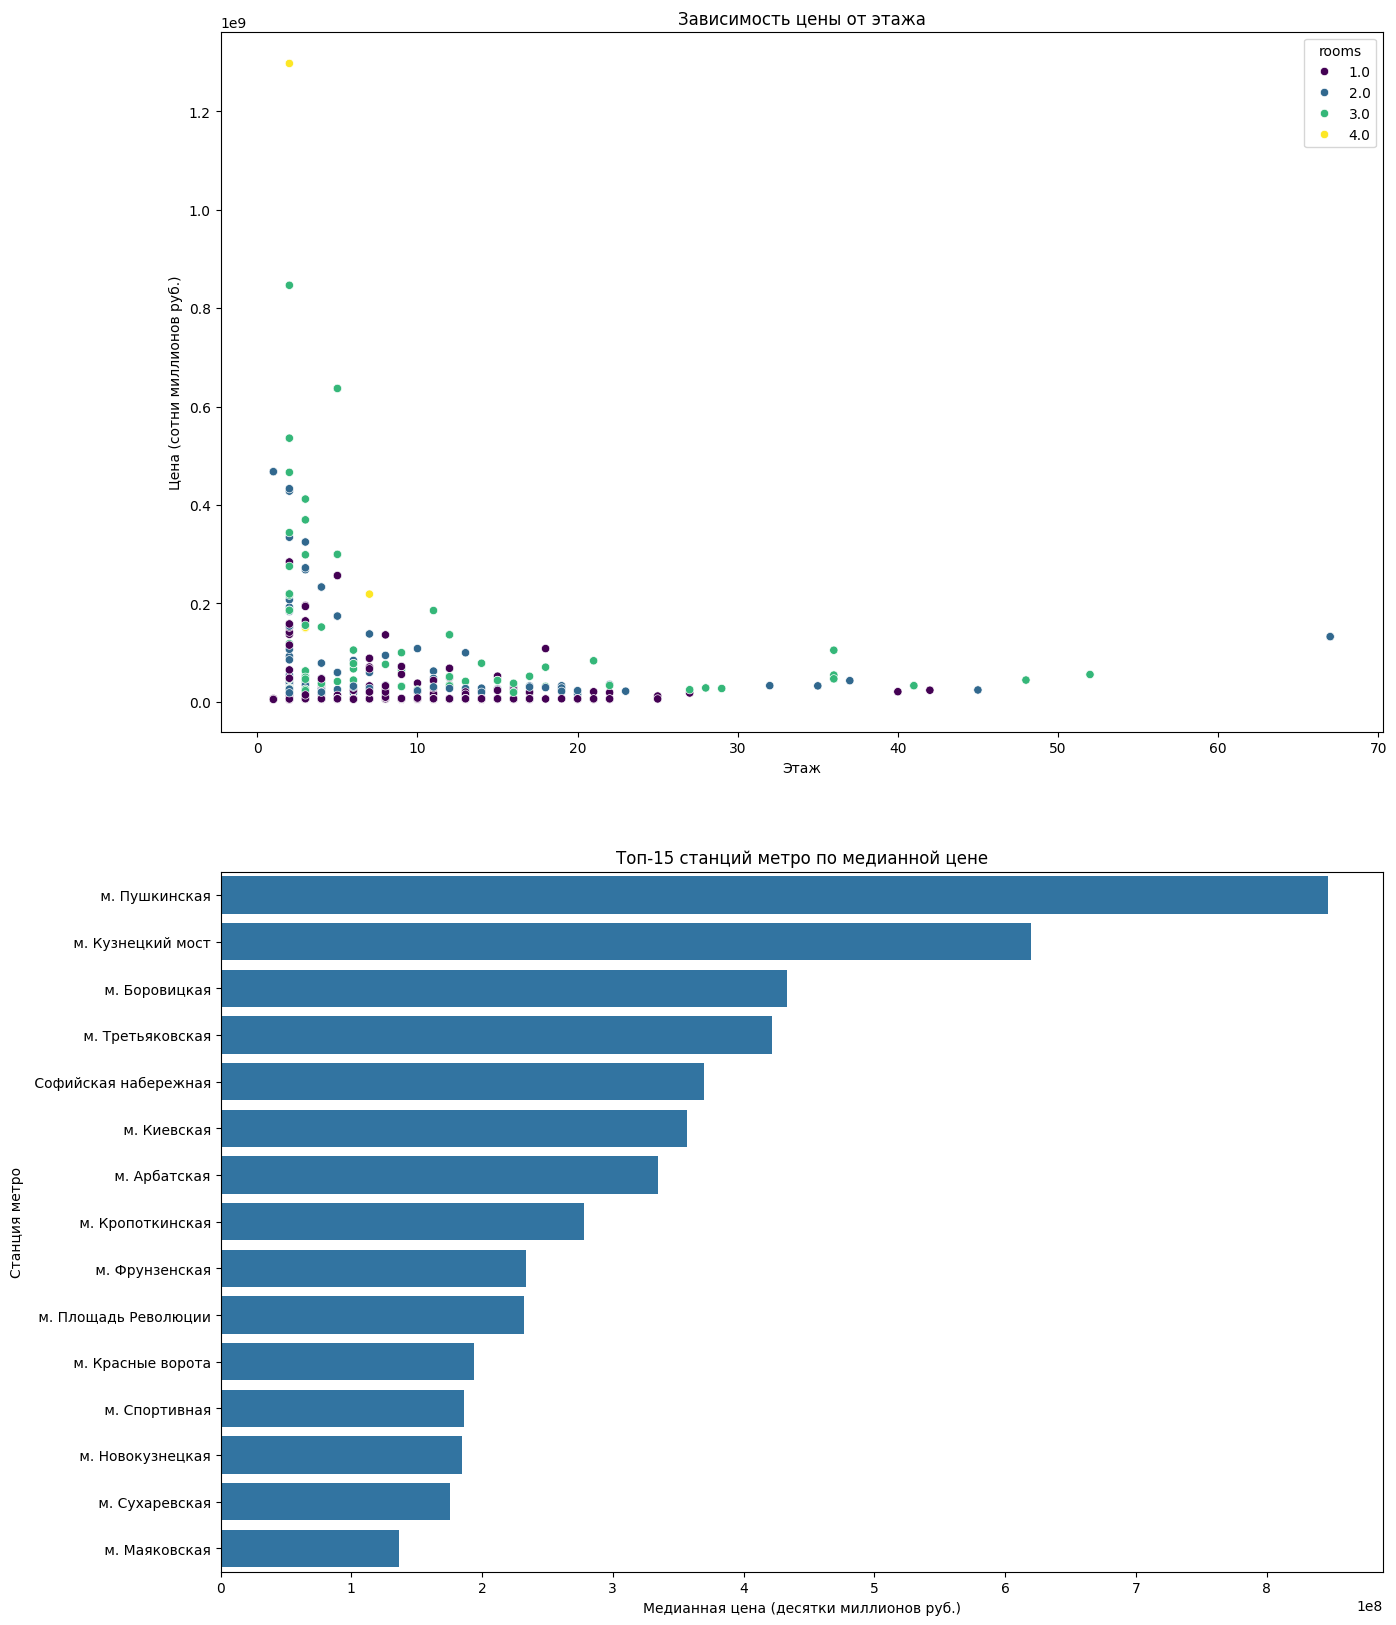

In [16]:
# 7. Визуализация зависимостей этаж/цена, метро/цена
plt.figure(figsize=(15, 20))

# Зависимость этаж/цена
plt.subplot(2, 1, 1)
sns.scatterplot(data=df, x='floor', y='price', hue='rooms', palette='viridis')
plt.title('Зависимость цены от этажа')
plt.xlabel('Этаж')
plt.ylabel('Цена (сотни миллионов руб.)')

# Зависимость метро/цена (используем 4-е значение из geo)
plt.subplot(2, 1, 2)
metro_prices = df.groupby('geo_3')['price'].median().sort_values(ascending=False).head(15)
sns.barplot(x=metro_prices.values, y=metro_prices.index)
plt.title('Топ-15 станций метро по медианной цене')
plt.xlabel('Медианная цена (десятки миллионов руб.)')
plt.ylabel('Станция метро')

In [18]:
with open('../artifacts/cian_dataset_enriched.dill', "wb") as f:
    try:
        dill.dump(df, f)
    except Exception as e:
        print(f"Ошибка загрузки данных: {e}")

## Выводы

Как же дорого жить в Москве!

Данные размечены ценой квартиры, предсказание которой от множества параметров является классической регрессионной задачей. Признаки подобраны так, чтобы было можно применить великое множество различных методов, от OHE до семантического анализа описания.

В этом ноутбуке приведены базовые обработки, которые позволят эффективно отточить навыки в ДЗ 2.